## File created by Reid Wyde


### Last updated 11.22.19



## todo:

finish updating the markdown with the correct equations

run the model

look at todo in model 3


# Data Driven Growth Models for Combination Therapy for HER2+ Breast Cancer

## Traversing differential equations parameter space using Markov Chain Monte Carlo

#### Background: Chemotherapy (Doxorubicin) and immunotherapy (Trastuzumab/Herceptin) were given to adult female rats previously injected with HER2+ breast cancer [ ]. Trastuzumab is understood to improve vascular regularization within tumors and improve chemotherapy efficacy [ ]. This project investigates growth models for HER2+ cancer in the presence of different combinations of Doxorubicin and Trastuzumab. The goal is to deliver a data validated growth model that informs optimal treatment using these therapies, as well as characterize the tumoral system, including the relationship between tumor size, natural growth rate, drug clearing rate, and magnitude of drug effect.

### Mathematical models of tumor growth and simulation visualizations provided by Dr. Ernesto Lima, Associate Researcher at The Center for Computational Oncology at The University of Texas, 2019. 

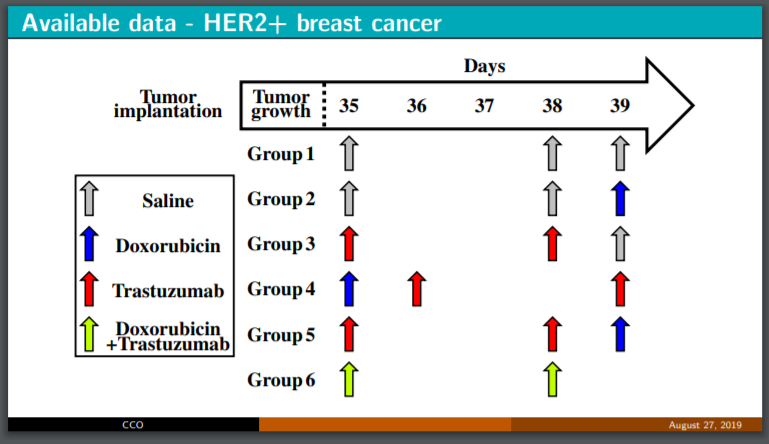

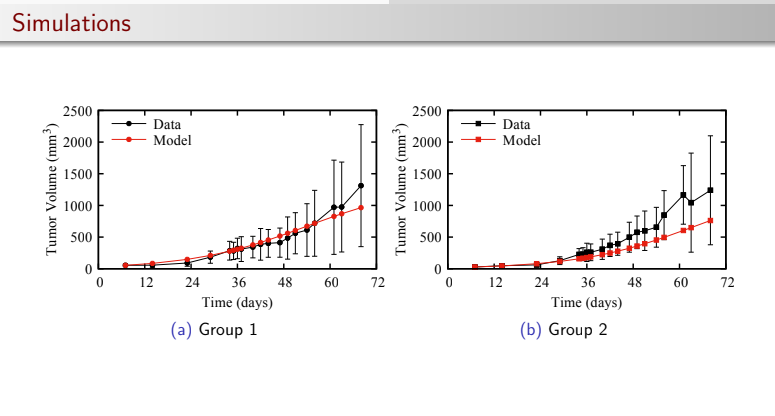

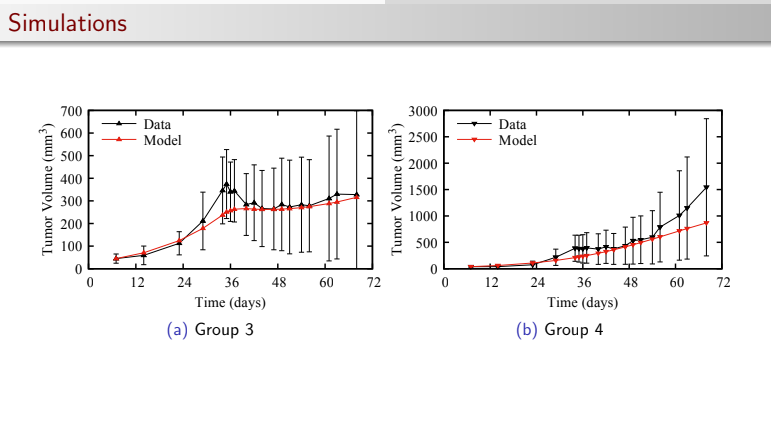

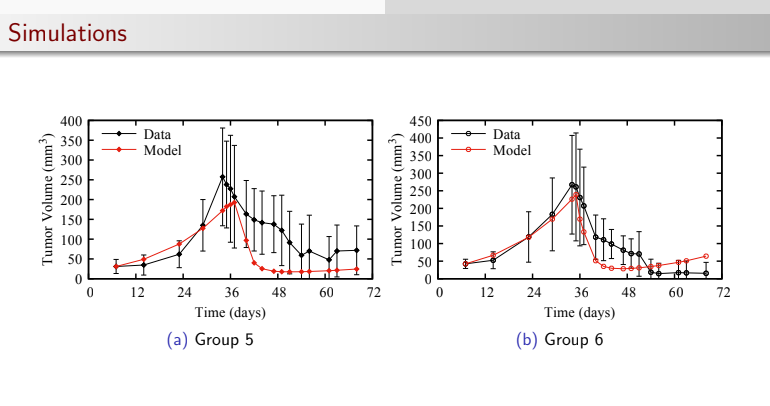

## Note: From here on, groups will be 0 indexed. i.e. group 0 is the control, group 5 is the simultaneous combination therapy

## General Strategy:  We will fit parameters one group at a time. Group 0 will parameterize the natural growth rate of cancer. Group 1 will parameterize Doxorubicin in isolation. Group 2 will parameterize Herceptin (Trastuzumab) in isolation. Groups 3, 4, and 5 will parameterize the drug-drug interaction. 


## This greedy strategy is motivated by the understanding that MCMC doesn't converge effectively for large dimensionality, models tend to get stuck. 

## New Model Iteration: Multiple Differential Equations

### Until now, we have considered the HER2+ cancer system as a single differential equation. We will now hypothesize that the system can be parameterized by multiple ODEs. 

### We will parameterize two different systems. The first system will be comprised of three differential equations. These equations will describe tumor growth, effective doxorubicin presence, and effective herceptin presence in the cancer system. 


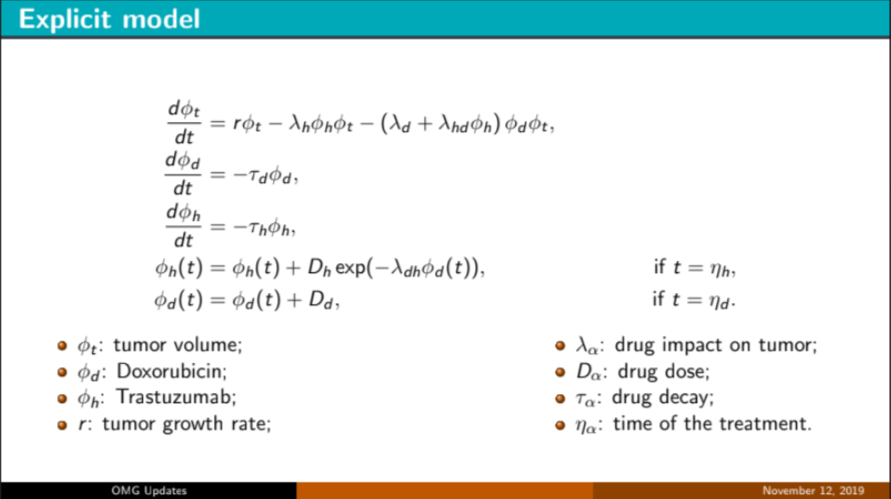


### Ernesto's System

$$ \frac{dT}{dt} = (r - \lambda_H H - (\lambda_D + \lambda_HD H) \;D) \; T $$

$$ \frac{dD}{dt} = - \tau_D D $$

$$ \frac{dH}{dt} = - \tau_H H $$

$$ H(t) = H(t) + \delta_H e^{-\lambda_{DH}}{D(t)} $$

$$ D(t) = D(t) + \delta_D $$


With:


$ r $ The natural growth rate

$ \lambda_H $ The effect of Herceptin on the tumor (likely through immune signalling) 

$ \lambda_{OD} $ The effect of Doxorubicin on the number of ROS

$ \lambda_{ODH} $ The synergistic effect of Herceptin's NRF2 suppression and Doxorubicin's production of ROS

$ \lambda_{DH} $ Herceptin's suppression of NRF2 on Doxorubicin clearing rate 

$$
\;
\;
$$


$ \tau_O $ The natural clearing rate of ROS

$ \tau_H $ The natural clearing rate of Herceptin

$ \tau_D $ The natural clearing rate of Doxorubcin

$$
\;
\;
$$


$ \delta_H $ The Kronecker delta representing Herceptin drug delivery on the specified treatment days

$ \delta_D $ The Kronecker delta representing Doxorubicin drug delivery on the specified treatment days





# Code

#### If the imports fail, run the install_packages notebook

In [12]:
#!MKL_THREADING_LAYER=GNU

In [13]:
#visualization
import matplotlib.pyplot as plt

#arrays
import numpy as np

#file system
import os
import platform

#CSV read
import pandas as pd

#model building
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

np.random.seed(123)

In [14]:
if platform.system() == 'Windows':  # check the file system formatting
    filtered_filename = os.getcwd() + '\..\data\\filtered_data_csv.csv'
else:
    filtered_filename = os.getcwd() + '/../data//filtered_data_csv.csv'
    
tumor_size_db = pd.read_csv(filtered_filename)
#tumor_size_db.head()

In [15]:
ts = np.array(tumor_size_db['Day']).transpose() # dimension: (19,)
Ts = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

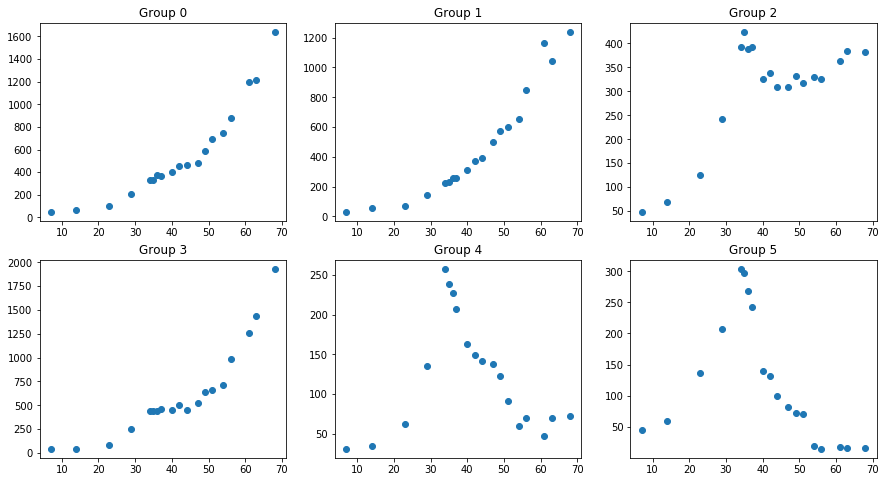

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
for group in range(6):
    axs[int(group/3), int(group%3)].title.set_text('Group ' + str(group))
    axs[int(group/3), int(group%3)].scatter(ts, Ts[group])
plt.show()

## Treatment model - Impulse

In [17]:
def get_tt(tuple_treatment_group):
    switcher={
        ('dox',1): [39],
        
        ('her',2): [35,38],
        
        ('dox',3): [35],
        ('her',3): [36,39],
        
        ('her',4): [35,38],
        ('dox',4): [39],
        
        ('her',5): [35,38],
        ('dox',5): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])

def get_Sd_impulse(ts):
    Sds = np.zeros((6, len(ts)))
    for group in range(6):
        treatment_times = get_tt(('dox', group))
        for tt in treatment_times:
            ii = np.where(ts > tt)[0][0]
            Sds[group, ii] = 1
    return Sds
    
def get_Sh_impulse(ts):
    Shs = np.zeros((6, len(ts)))
    for group in range(6):
        treatment_times = get_tt(('her', group))
        for tt in treatment_times:
            ii = np.where(ts > tt)[0][0]
            Shs[group, ii] = 1
    return Shs

def get_Sd_impulse_by_group(ts, group):
    Sds = np.zeros((1, len(ts)))
    treatment_times = get_tt(('dox', group))
    for tt in treatment_times:
        ii = np.where(ts > tt)[0][0]
        Sds[0, ii] = 1
    return Sds
    
def get_Sh_impulse_by_group(ts, group):
    Shs = np.zeros((1, len(ts)))
    treatment_times = get_tt(('her', group))
    for tt in treatment_times:
        ii = np.where(ts > tt)[0][0]
        Shs[0, ii] = 1
    return Shs

def get_Sd_impulse_Combination(ts, group_idxs):
    Sds = np.zeros((len(group_idxs), len(ts)))
    for ii in range(len(group_idxs)):
        group_idx = group_idxs[ii]
        treatment_times = get_tt(('dox', group_idx))
        for tt in treatment_times:
            jj = np.where(ts > tt)[0][0]
            Sds[ii, jj] = 1
    return Sds

def get_Sh_impulse_Combination(ts, group_idxs):
    Shs = np.zeros((len(group_idxs), len(ts)))
    for ii in range(len(group_idxs)):
        group_idx = group_idxs[ii]
        treatment_times = get_tt(('her', group_idx))
        for tt in treatment_times:
            jj = np.where(ts > tt)[0][0]
            Shs[ii, jj] = 1
    return Shs

### Treatment calculation unit tests

teatment impulse


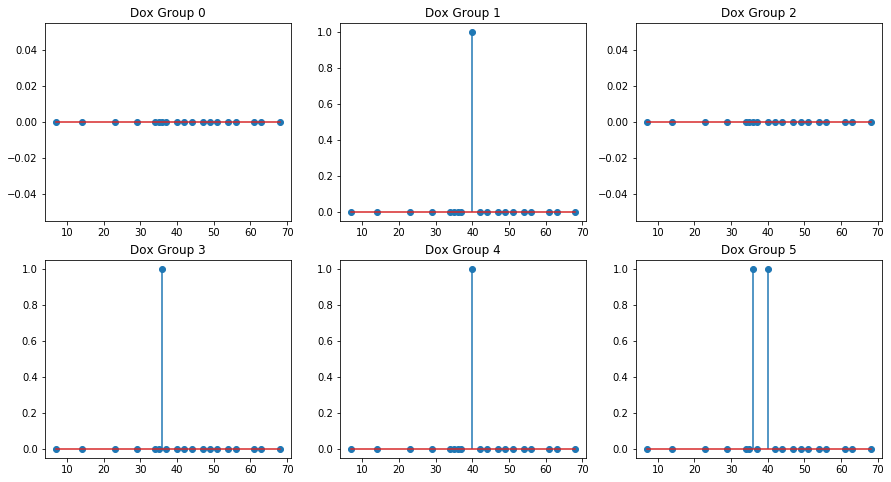

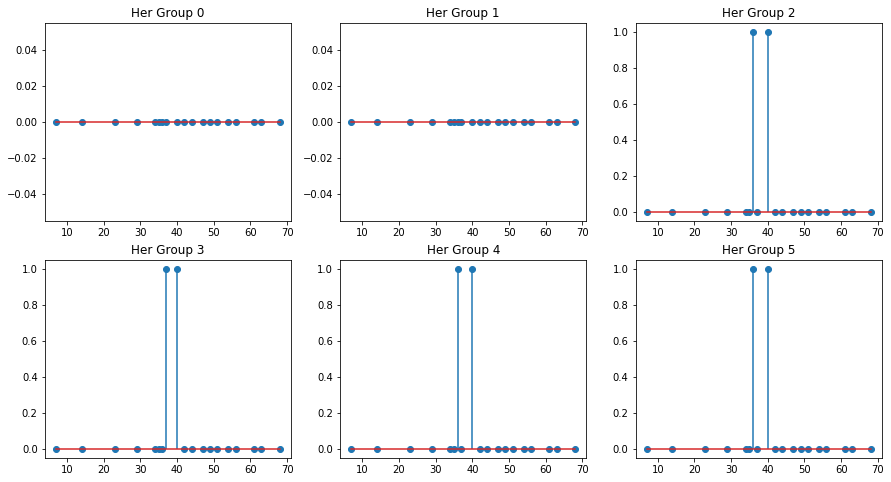

treatment impulse by group


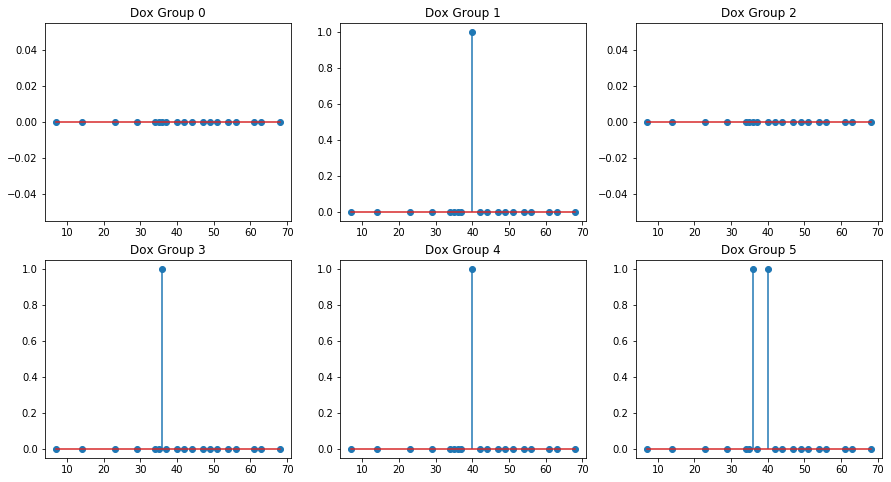

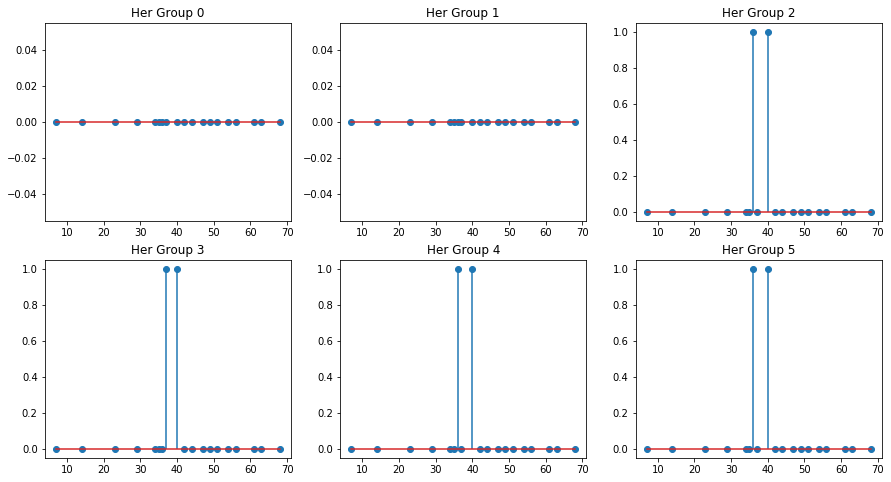

In [18]:
def test_treatment_Sd_impulse():
    tau_d=0.1
    Sds = get_Sd_impulse(ts)
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Sds[group], use_line_collection=True)
    plt.show()
    return

def test_treatment_Sh_impulse():
    Shs = get_Sh_impulse(ts)
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Shs[group], use_line_collection=True)
    plt.show()
    return


def test_treatment_Sd_impulse_by_group():
    Sds = np.zeros((6, len(ts)))
    for group in range(6):
        Sds[group,:] = get_Sd_impulse_by_group(ts, group)
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Sds[group], use_line_collection=True)
    plt.show()
    return


def test_treatment_Sh_impulse_by_group():
    #ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    for group in range(6):
        Shs[group,:] = get_Sh_impulse_by_group(ts, group)
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Shs[group], use_line_collection=True)
    plt.show()
    return


print('teatment impulse')
test_treatment_Sd_impulse()
test_treatment_Sh_impulse()

print('treatment impulse by group')
test_treatment_Sd_impulse_by_group()
test_treatment_Sh_impulse_by_group()



## Simulation Graphing Methods

In [19]:
sim_times = np.linspace(7,70,100*(70-7+1)) # original time indexing started at day 7

def graph_sim_by_group(sim_times, T_sim, group):
    plt.figure(figsize=[4,2.5])
    plt.scatter(ts, Ts[group,:])
    plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
    plt.plot(sim_times, T_sim)
    plt.title('Group ' + str(group))
    plt.xlabel('Day')
    plt.ylabel('Size')
    plt.show()
    
def graph_sim(sim_times, T_sim):
    plt.figure(figsize=[16,10])
    for group in range(6):
        plt.subplot(2,3,group+1)
        plt.scatter(ts, Ts[group,:])
        plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
        plt.plot(sim_times, T_sim[group,:])
        plt.title('Group ' + str(group))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()

## Forward DE Models

In [20]:
def rk_var_update(var, ks):
    k1, k2, k3, k4 = [x for x in ks]
    var = var + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    var[var<0] = 0
    return var

def rk_T(h, t0, T, H, O, params, j, dTdt):
    k1 = h * dTdt(t0, T, H, O, params, j) 
    k2 = h * dTdt(t0+0.5*h, T + 0.5 * k1, H, O, params, j) 
    k3 = h * dTdt(t0+0.5*h, T + 0.5 * k2, H, O, params, j) 
    k4 = h * dTdt(t0+h, T + k3, H, O, params, j)   
    return k1, k2, k3, k4

def rk_D(h, t0, D, params, j, dDdt):
    k1 = h * dDdt(t0, D, params, j) 
    k2 = h * dDdt(t0+0.5*h, D + 0.5 * k1, params, j) 
    k3 = h * dDdt(t0+0.5*h, D + 0.5 * k2, params, j) 
    k4 = h * dDdt(t0+h, D + k3, params, j)   
    return k1, k2, k3, k4
    
def rk_H(h, t0, H, D, params, j, dHdt):
    k1 = h * dHdt(t0, H, D, params, j) 
    k2 = h * dHdt(t0+0.5*h, H + 0.5 * k1, D, params, j) 
    k3 = h * dHdt(t0+0.5*h, H + 0.5 * k2, D, params, j) 
    k4 = h * dHdt(t0+h, H + k3, D, params, j) 
    return k1, k2, k3, k4

def rk_O(h, t0, O, D, H, params, j, dOdt):
    k1 = h * dOdt(t0, O, D, H, params, j) 
    k2 = h * dOdt(t0+0.5*h, O + 0.5 * k1, D, H, params, j) 
    k3 = h * dOdt(t0+0.5*h, O + 0.5 * k2, D, H, params, j) 
    k4 = h * dOdt(t0+h, O + k3, D, H, params, j)
    return k1, k2, k3, k4


def rungeKutta_all_params(ts, T0, dTdt, dDdt, dHdt, dOdt, Sds, Shs, params):
    r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D = [x for x in params]
    time_len = len(ts.ravel())
    ret_T = np.zeros((T0.shape[0], time_len))
    ret_D = np.zeros(ret_T.shape)
    ret_H = np.zeros(ret_T.shape)
    ret_O = np.zeros(ret_T.shape)
    T = T0
    D = ret_D[:,0]
    H = ret_H[:,0]
    O = ret_O[:,0]
    ret_T[:, 0] = T0
    for i in range(1, time_len):
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0
        Sd = Sds[:,i-1]
        Sh = Shs[:,i-1]

        D_new = rk_var_update(D, rk_D(h, t0, D, params, i-1, dDdt)) + Sd
        H_new = rk_var_update(H, rk_H(h, t0, H, D, params, i-1, dHdt)) + Sh*np.exp(-lambda_HD*D)
        O_new = rk_var_update(O, rk_O(h, t0, O, D, H, params, i-1, dOdt))
        T_new = rk_var_update(T, rk_T(h, t0, T, H, O, params, i-1, dTdt))
        
        D = D_new
        H = H_new
        O = O_new         
        T = T_new 
        
        ret_T[:,i] = T
        ret_D[:,i] = D
        ret_H[:,i] = H
        ret_O[:,i] = O
    
    return ret_T, ret_D, ret_H, ret_O

## Growth Model Class

In [21]:
class growth_model(object):
    def __init__(self, times, T0):
        self._times = times
        self._T0 = T0
        
    def dTdt(self, *argv):
        return 0
    def dDdt(self, *argv):
        return 0
    def dHdt(self, *argv):
        return 0
    def dOdt(self, *argv):
        return 0
   
    def get_param(self, param_name, n=10):
        return pm.summary(self.trace)['mean'][param_name]

## Combinational Therapy


$$ \frac{dT}{dt} = (r - \lambda_O O) T $$


$$ \frac{dO}{dt} = \lambda_{OH} H + \lambda_{ODH} D H - \tau_O O $$


$$ \frac{dH}{dt} = \delta_He^{-\lambda_{HD}D} - \tau_H H $$


$$ \frac{dD}{dt} = \delta_D - \tau_D D $$


r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D

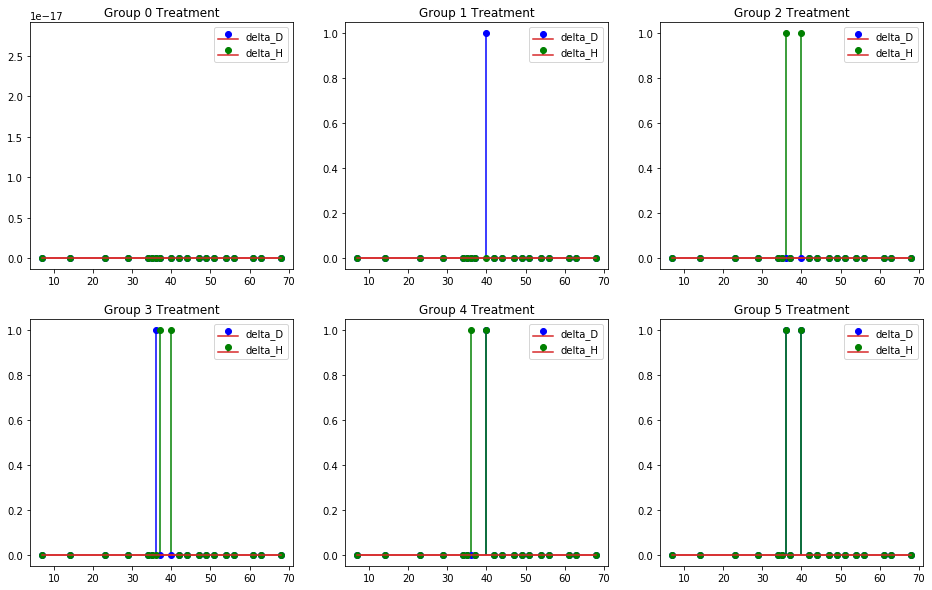

Only 250 samples in chain.
Sequential sampling (20 chains in 1 job)
CompoundStep
>Metropolis: [tau_D]
>Metropolis: [tau_H]
>Metropolis: [lambda_HD]
>Metropolis: [tau_O]
>Metropolis: [lambda_ODH]
>Metropolis: [lambda_OH]
>Metropolis: [lambda_O]
>Metropolis: [r]
 40%|███████████████████████████████▋                                                | 119/300 [00:10<00:15, 12.03it/s]

In [ ]:
class growth_model_4(growth_model):
    def __init__(self):
        super().__init__(ts, np.array(Ts[:,0]).reshape(-1,))
        self.groups = [0,1,2,3,4,5]
        self._times = ts
        
        self.Sds_fit = get_Sd_impulse(ts)
        self.Shs_fit = get_Sh_impulse(ts)
        
        self.Sds_sim = get_Sd_impulse(sim_times)
        self.Shs_sim = get_Sh_impulse(sim_times)
        
        self.Sds = self.Sds_fit
        self.Shs = self.Shs_fit 
        
        
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.stem(ts, self.Sds[ii,:], 'b', markerfmt='bo', label='delta_D', use_line_collection=True)
            plt.stem(ts, self.Shs[ii,:], 'g', markerfmt='go', label='delta_H', use_line_collection=True)
            plt.title('Group ' + str(group) + ' Treatment')
            plt.legend()
        plt.show()
         
    def _simulate(self, params, times):
        self.sim_T, self.sim_D, self.sim_H, self.sim_O = rungeKutta_all_params(times, \
                            self._T0, self.dTdt, self.dDdt, self.dHdt, self.dOdt, self.Sds, self.Shs, params)
        return self.sim_T
    
    def simulate(self, r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D, times=None):
        if times is None: times = self._times        
        return self._simulate([r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D], times)
    
    def dDdt(self, t, D, params, i):
        #r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D = [x for x in params]
        tau_D = params[7]
        return -tau_D*D
    
    def dHdt(self, t, H, D, params, i):
        #r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D = [x for x in params]
        tau_H = params[6]
        return -tau_H*H
    
    def dOdt(self, t, O, D, H, params, i):
        #r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D = [x for x in params]
        lambda_OH = params[2]
        lambda_ODH = params[3]
        tau_O = params[4]
        return lambda_OH*H + lambda_ODH*D*H - tau_O*O
    
    def dTdt(self, t, T, H, O, params, i):
        #r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D = [x for x in params]
        r = params[0]
        lambda_O = params[1]
        return (r - lambda_O*O)*T
    
    def backward(self):
        T_obs = Ts
        sigmas_obs = np.ones(T_obs.shape)
        with pm.Model():
            self.param_list = ['r', 'lambda_O', 'lambda_OH', 'lambda_ODH', 'tau_O', 'lambda_HD', 'tau_H', 'tau_D']
            
            r_lower = 0.0001
            r_upper = 0.1
            
            lambda_O_lower = 0
            lambda_O_upper = 0.1
            
            lambda_OH_lower = 0 
            lambda_OH_upper = 1
                            
            lambda_ODH_lower = 0
            lambda_ODH_upper = 5
            
            tau_O_lower = 0
            tau_O_upper = 0.2
   
            lambda_HD_lower = 0
            lambda_HD_upper = 10

            tau_H_lower = 0
            tau_H_upper = 0.3
                        
            tau_D_lower = 0 
            tau_D_upper = 0.5
            
            #r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            lambda_O = pm.Uniform('lambda_O', lower=lambda_O_lower, upper=lambda_O_upper)
            lambda_OH = pm.Uniform('lambda_OH', lower=lambda_OH_lower, upper=lambda_OH_upper)
            lambda_ODH = pm.Uniform('lambda_ODH', lower=lambda_ODH_lower, upper=lambda_ODH_upper)
            tau_O = pm.Uniform('tau_O', lower=tau_O_lower, upper=tau_O_upper)
            lambda_HD = pm.Uniform('lambda_HD', lower= lambda_HD_lower, upper= lambda_HD_upper)
            tau_H = pm.Uniform('tau_H', lower= tau_H_lower, upper= tau_H_upper)
            tau_D = pm.Uniform('tau_D', lower= tau_D_lower, upper= tau_D_upper)
            
            ## Theano wrapper is necessary in order to pass the forward evolution to PyMC3
            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D):
                th_states = self.simulate(r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D)
                return th_states
            
            forward = th_forward_model(r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 20
            startsmc=[{'r':np.random.uniform(r_lower, r_upper),
                       'lambda_O':np.random.uniform(lambda_O_lower, lambda_O_upper),
                       'lambda_OH':np.random.uniform(lambda_OH_lower, lambda_OH_upper),                      
                       'lambda_ODH':np.random.uniform(lambda_ODH_lower, lambda_ODH_upper),
                       'tau_O':np.random.uniform(tau_O_lower, tau_O_upper),
                       'lambda_HD':np.random.uniform(lambda_HD_lower, lambda_HD_upper),
                       'tau_D':np.random.uniform(tau_D_lower, tau_D_upper),
                       'tau_H':np.random.uniform(tau_H_lower, tau_H_upper), 
                      } for _ in range(n_chains)]
            num_samples = 250 # Within each chain, operations are sequential and cannot be parallelized.
            num_tune = int(num_samples/5)
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace)
            
    def plot_short(self, times, var, title):
        plt.figure()
        plt.plot(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
        
    def stem_short(self, times, var, title):
        plt.figure()
        plt.stem(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
                
    def graph_sims(self, sim_times, T_sim):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.figure()
            plt.scatter(ts, Ts[group,:])
            plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.', capsize=2)
            plt.plot(sim_times, T_sim[ii,:])
            plt.title('Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
            
        self.sim_D, self.sim_H, self.sim_O 
            
                
    def graph_Sds(self, times):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            plt.figure()
            group = self.groups[ii]
            plt.stem(times, self.Sds[ii, :])
            plt.title('Group ' + str(group) + ' Sd')
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
    
    def graph_Shs(self, times):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            plt.figure()
            group = self.groups[ii]
            plt.stem(times, self.Shs[ii, :])
            plt.title('Group ' + str(group) + ' Sh')
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
            
    def graph_D(self, sim_times):
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.plot(sim_times, self.sim_D[ii,:])
            plt.title('D for Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('amt')
        plt.show()
        
    def graph_H(self, sim_times):
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.plot(sim_times, self.sim_H[ii,:])
            plt.title('H for Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('amt')
        plt.show()
        
    def graph_O(self, sim_times):
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.plot(sim_times, self.sim_O[ii,:])
            plt.title('O for Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('amt')
        plt.show()
    
    
    def sim_graph_model():
        this_model = growth_model_4()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        
        #save0
        r = 0.060241056889849875
        lambda_O = 0.05289605625671938
        lambda_OH = 0.45468408052396453
        lambda_ODH = 2.4608911506715576
        tau_O = 0.1333684782466068
        lambda_HD = 9.968412801121227
        tau_H = 0.19805520350427036
        tau_D = 0.0744862507628809
       
        T_sim = this_model.simulate(r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D, sim_times)
        
        this_model.graph_sims(sim_times, T_sim)
        this_model.graph_D(sim_times)
        this_model.graph_H(sim_times)
        this_model.graph_O(sim_times)
        
        print('r = ' + str(r))
        print('lambda_O = ' +str(lambda_O))
        print('lambda_OH = ' + str(lambda_OH))
        print('lambda_ODH = ' + str(lambda_ODH))
        print('tau_O = ' + str(tau_O))
        print('lambda_HD = ' + str(lambda_HD)) 
        print('tau_H = ' + str(tau_H))
        print('tau_D = ' + str(tau_D))
        
        return r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D
    
    
    def fit_sim_graph_model():
        this_model = growth_model_4()
        this_model.backward()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D  = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D, sim_times)
        graph_sim(sim_times, T_sim)
        this_model.graph_D(sim_times)
        this_model.graph_H(sim_times)
        this_model.graph_O(sim_times)
        
        print('r = ' + str(r))
        print('lambda_O = ' +str(lambda_O))
        print('lambda_OH = ' + str(lambda_OH))
        print('lambda_ODH = ' + str(lambda_ODH))
        print('tau_O = ' + str(tau_O))
        print('lambda_HD = ' + str(lambda_HD)) 
        print('tau_H = ' + str(tau_H))
        print('tau_D = ' + str(tau_D))
        
        
        return r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D
    
    
r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D = growth_model_4.fit_sim_graph_model()
#r, lambda_O, lambda_OH, lambda_ODH, tau_O, lambda_HD, tau_H, tau_D = growth_model_4.sim_graph_model()
